# Recommendations with IBM

In the IBM Watson Studio, there is a large collaborative community ecosystem of articles, datasets, notebooks, and other A.I. and ML. assets. Users of the system interact with all of this. In this notebook, we create a recommendation system to enhance the user experience and connect them with assets. This personalizes the experience for each user. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
from statistics import mean, median
%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.tail()

,article_id,title,email
45988,1324.0,ibm watson facebook posts for 2015,d21b998d7a4722310ceeaa3c6aaa181a36db2d73
45989,142.0,neural networks for beginners: popular types a...,d21b998d7a4722310ceeaa3c6aaa181a36db2d73
45990,233.0,bayesian nonparametric models – stats and bots,4faeed980a7cd11e0f3cf2058cc04daa2ef11452
45991,1160.0,analyze accident reports on amazon emr spark,abbf639ba05daa5249c520e290283a6d726ba78d
45992,16.0,higher-order logistic regression for large dat...,1f18e8aaccd6c8720180c3fe264c8aef5b00697f


In [2]:
# Show df_content to get an idea of the data
df_content.tail()

,doc_body,doc_description,doc_full_name,doc_status,article_id
1051,PouchDB-find is a new API and syntax that allo...,PouchDB uses MapReduce as its default search m...,A look under the covers of PouchDB-find,Live,1046
1052,We compare discriminative and generative learn...,We compare discriminative and generative learn...,A comparison of logistic regression and naive ...,Live,1047
1053,"Essays about data, building products and boots...",In order to demystify some of the magic behind...,What I Learned Implementing a Classifier from ...,Live,1048
1054,NaN,Learn how to use IBM dashDB as data store for ...,Use dashDB with Spark,Live,1049
1055,Homepage Follow Sign in / Sign up Homepage * H...,Once you get used to developing in a Notebook ...,"Jupyter Notebooks with Scala, Python, or R Ker...",Live,1050


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Here, we provide some insight into the descriptive statistics of the data.

In [3]:
v_user_article=df.groupby(['email'])['article_id'].nunique().tolist()

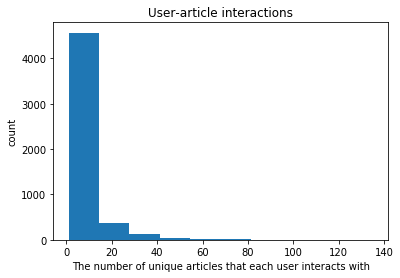

In [4]:
plt.hist(v_user_article,bins=10)
plt.xlabel("The number of unique articles that each user interacts with")
plt.ylabel("count")
plt.title('User-article interactions')
plt.show()

In [5]:
v_user_interact=df.groupby(['email','article_id']).count().values.tolist()

In [6]:
# Fill in the median and maximum number of user_article interactios below

median_val =median(v_user_article) # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = max(df.groupby(['email'])['article_id'].count())# The maximum number of user-article interactions by any 1 user is ______.

 Explore and remove duplicate articles from the **df_content** dataframe.  

In [7]:
# Find and explore duplicate articles
df_content_duplicate= df_content [df_content.duplicated(['article_id'])]

In [8]:
df_content_duplicate.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [9]:
# Remove any rows that have the same article_id - only keep the first
df_content=df_content.drop_duplicates(subset=['article_id'], keep='first')

Here, we extract the following infomation:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [10]:
unique_articles = df['article_id'].nunique()# The number of unique articles that have at least one interaction
total_articles =  df_content['article_id'].nunique()# The number of unique articles on the IBM platform
unique_users =  df['email'].nunique()# The number of unique users
user_article_interactions = df.shape[0]# The number of user-article interactions

In [11]:
most_viewed_article_id = str(df['article_id'].value_counts().idxmax())# The most viewed article in the dataset as a string with one value following the decimal 
max_views = df['article_id'].value_counts().max()# The most viewed article in the dataset was viewed how many times?

 Next we map users to ids.  There were a small number of null values, and all of these null values belonged to a single user (which is how they are stored using the function below).

In [12]:
## maping the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [13]:
## tests

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

 In this section, we design our rank-based recommender. In this case, the popularity of an article can really only be based on how often an article interacted with.

The following function returns the **n** top articles ordered with most interactions as the top.

In [14]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    num_viewed_articles = df['title'].value_counts()
    top_articles=num_viewed_articles[:n].index.tolist()
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article ids 
    
    '''
    num_viewed_articles = df['article_id'].value_counts().index.tolist()
    top_articles=num_viewed_articles[:n]
    top_articles =[str(x) for x in top_articles ]
 
    return top_articles # Return the top article ids

In [15]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [16]:
# Test our function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


In this section, first, we reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 


In [17]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    df_new=df.groupby(['article_id', 'user_id']).count().reset_index()
    df_new=df_new.pivot_table(index='user_id',columns='article_id',values='title')
    df_new = df_new.replace(np.nan, 0)
    user_item=df_new.applymap(lambda x: 1 if x > 0 else x)
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [18]:
## Tests
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


 The following function takes a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar). The returned result does not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

In [19]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    user_sim=user_item[user_item.index == user_id].dot(user_item.T)

    # sort by similarity
    df_similarity=user_sim.sort_values(by=user_id, axis=1, ascending=False)

    # create list of just the ids
    most_similar_users=df_similarity.columns.tolist()
   
    # remove the own user's id
    most_similar_users.remove(user_id)
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [20]:
# spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


Next we use the following functions to return the articles we would recommend to each user. 

In [21]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names= set(list(df[df['article_id'].isin(article_ids)]['title']))
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    series=user_item.iloc[user_id-1]
    article_ids=series.loc[series[:]==1.0].index.tolist()
    article_names=df[df['article_id'].isin(article_ids)]['title']
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    article_ids, article_names = get_user_articles(user_id)
    closest_neighbors=find_similar_users(user_id, user_item=user_item)
    recs = list()
    for neighbor in closest_neighbors:
        _,neigh_likes = get_user_articles(neighbor)
        new_recs = list(set(neigh_likes.tolist()) - set( article_names ))
        recs.extend(new_recs)
        recommendation=recs[0:m]
    
    return recommendation# return your recommendations for this user_id    

In [22]:
# Check Results
user_user_recs(2, 10) # Return 10 recommendations for user 1

['insights from new york car accident reports',
 'analyze open data sets with spark & pixiedust',
 'python if statements explained (python for data science basics #4)',
 'machine learning exercises in python, part 1',
 'putting a human face on machine learning',
 '9 mistakes to avoid when starting your career in data science',
 'deploy your python model as a restful api',
 'using machine learning to predict baseball injuries',
 '10 must attend data science, ml and ai conferences in 2018',
 'neural language modeling from scratch (part 1)']

In [23]:
# Test 
assert set(get_article_names([1024.0, 1176.0, 1305.0, 1314.0, 1422.0, 1427.0])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names([1320.0, 232.0, 844.0])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set([1320.0, 232.0, 844.0])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set([1024.0, 1176.0, 1305.0, 1314.0, 1422.0, 1427.0])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function that we wrote earlier.

In [67]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user
                    to the provided user_id
                    num_interactions - the number of articles 
                    viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and 
                    then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    v_interactions=list()
    # creating the dataframe
    neighbors_df= pd.DataFrame()
    # saving user ids 
    user_sim = user_item.dot(user_item.loc[user_id]).sort_values(ascending=False)
    user_sim.drop(user_id, inplace=True)
    v_sorted=user_sim.index.tolist()
    # recording 
    for ids in v_sorted:
        v_interactions.append(df[df['user_id']==ids].shape[0])
    # importing data into the dataframe 
    neighbors_df['user_id']=v_sorted
    neighbors_df['similarity']=user_sim.values.tolist()
    neighbors_df['num_interactions']=v_interactions
    # sorting the dataframe 
    neighbors_df = neighbors_df.sort_values(['similarity', 'num_interactions'],
              ascending = [False, False])
    neighbors_df = neighbors_df[neighbors_df.user_id != user_id]
    
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    v_list = []
    article_ids, article_names = get_user_articles(user_id)
    top_similar_user = get_top_sorted_users(user_id).user_id
    for ids in top_similar_user.tolist():
        article_id, article_name = get_user_articles(ids)
        new_recommend = np.setdiff1d(article_id, article_ids, 
                                     assume_unique= True)
        np.unique(v_list.append(new_recommend))
    v_list = np.concatenate(v_list, axis=0)
    recs = v_list[:m]
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [68]:
# Quick spot check 
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[  12.  109.  125.  142.  164.  205.  302.  336.  362.  465.]

The top 10 recommendations for user 20 are the following article names:
{'dsx: hybrid mode', 'learn tensorflow and deep learning together and now!', 'accelerate your workflow with dsx', 'introduction to neural networks, advantages and applications', 'statistics for hackers', 'tensorflow quick tips', 'challenges in deep learning', 'neural networks for beginners: popular types and applications', "a beginner's guide to variational methods", 'timeseries data analysis of iot events by using jupyter notebook'}


In [71]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1)['user_id'][0]# Find the user that is most similar to user 1 
user131_10th_sim =get_top_sorted_users(131)['user_id'][9] # Find the 10th most similar user to user 131

In [72]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


**We can recommend the most viewed articles to new users. Indeed, I would use the get_top_article_ids(10) function. However, the downside of this method is that the provided recommendation is general, not personalized.**

 Next, we test our function.

In [30]:
new_user = '0.0'

# Provide a list of the top 10 article ids you would give to a new user
new_user_recs = get_top_article_ids(10)# Your recommendations here



In [31]:
# test
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, we will build our recommendation engine using matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

In [82]:
# Load the matrix
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [83]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Since in this case, our user_item_matrix has not any NaN values, we can use SVD decomposition.**

In [84]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)# use the built in to get the three matrices

Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, we can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix. 

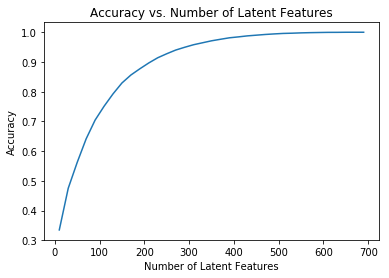

In [85]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

In [86]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # creating user_item_train, user_item_test, test_idx, test_arts
    user_item_train = create_user_item_matrix(df_train)

    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = user_item_test.index

    test_arts =  user_item_test.columns.values
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data.

In [76]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)# fit svd similar to above then use the cells below

In [77]:
def get_train_test(user_item_train,user_item_test,u_train,vt_train ):
    # getting train ids
    train_ids = user_item_train.index
    # getting common user ids and articles between training and test data 
    train_common_ids = user_item_train.index.isin(test_idx)
    train_common_arts = user_item_train.columns.isin(test_arts)
    # getting u_test and vt_test
    u_test = u_train[train_common_ids, :]
    vt_test = vt_train[:, train_common_arts]
    # getting the test data that we can conduct prediction
    common_ids = set(set(train_ids) & set(test_idx))
    user_item_test = user_item_test.loc[common_ids]
    
    return u_test,vt_test, user_item_test

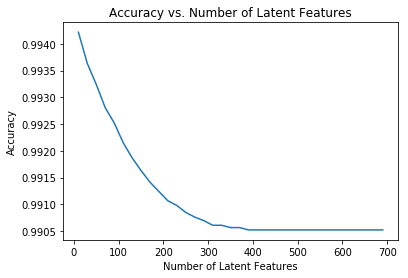

In [78]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []
u_test,vt_test, user_item_test=get_train_test(user_item_train,user_item_test,u_train,vt_train )

for k in num_latent_feats:
    # getting SVD decompositions of test data
    s_train_sample, u_train_sample, vt_train_sample = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_sample, vt_test_sample = u_test[:, :k], vt_test[:k, :]
    
    # getting the estimates
    user_item_est = np.around(np.dot(np.dot(u_test_sample, s_train_sample), 
                                     vt_test_sample))
    
    # getting error of prediction
    diffs_est = np.subtract(user_item_test, user_item_est)
    
    # getting errors
    
    test_err = np.sum(np.sum(np.abs(diffs_est)))
    sum_errs.append(test_err)
    
# plotting accurcy versus number of latent variables     
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

**In contrast with the training data, the accuracy of the model on the test data drops with increasing the number of latent features. The reason for observing such a result is that increasing the number of latent features causes overfitting during training.**

**To assess the performance of our recommenders, we can conduct an A/B test. To this end, we can divide our customers into two different groups using cookies. The first group will see the recommendation provided by the matrix factorization method, and the second group will see the recommendations provided by the rank-based recommendation method.**